In [100]:
import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state
from ACS_data import colname_mask
import re
import pickle

pd.set_option('display.max_columns', None)

In [87]:
import os
os.chdir('/home/marylena/Documents/ConsultingProject')
county_spending=get_county_spending()
#df = pd.read_pickle('merged_df.pkl')
#df.head()


In [88]:
#county_spending[county_spending['display_name']==None]

county_spending['county_name'] = county_spending['display_name'].apply(lambda x: str(x)+" County")

county_spending.head()

,amount,award_count,display_name,per_capita,population,shape_code,county_name
0,3.732767e+10,801724,Los Angeles,3718.23,10039107.0,06037,Los Angeles County
1,1.025893e+10,449512,Miami-Dade,3775.91,2716940.0,12086,Miami-Dade County
2,2.936372e+10,440456,Cook,5701.44,5150233.0,17031,Cook County
3,1.508957e+10,302025,Harris,3201.47,4713325.0,48201,Harris County
4,7.474199e+09,244142,Broward,3827.47,1952778.0,12011,Broward County


In [96]:
newacs = pd.read_csv('newACS.csv', index_col=0)
newacs['State'] = newacs.index
newacs['State'] = newacs.State.apply(lambda x: x[x.find(',')+2:])
newacs['State'] = newacs.State.apply(lambda x: x[:x.find(':')])
newacs['county_name'] = [newacs.index[x].split(",")[0] for x in range(len(newacs.index))]

newacs['State'] = newacs['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
newacs['population'] = newacs['male']+newacs['female']

newacs.head()

,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with private health insurance,people with public health insurance,people without health insurance,people with a disability,male,female,people that are older than 65,median household income,median age,white,black or african american,american indian and alaska native,asian,native hawaiian and other pacific islander,hispanic or latino,other races,State,county_name,population
"Fayette County, Illinois: Summary level: 050, state:17> county:051",8760,525,9285,5.7,11692,9395,1644,3527.0,11469,10096,4058,46650,41.9,20245,1007,68,116,28,403,13,IL,Fayette County,21565
"Logan County, Illinois: Summary level: 050, state:17> county:107",12426,738,13164,5.6,19106,9777,1154,3917.0,14298,14705,5224,57308,40.1,25667,2003,73,218,10,985,230,IL,Logan County,29003
"Saline County, Illinois: Summary level: 050, state:17> county:165",9902,816,10718,7.6,14218,12485,993,5240.0,11807,12187,4785,44090,42.2,22234,632,53,178,54,428,122,IL,Saline County,23994
"Lake County, Illinois: Summary level: 050, state:17> county:097",351926,19357,371283,5.2,519407,186251,46304,62508.0,350466,351007,96339,89427,38.4,531609,47385,2162,54157,285,152141,45309,IL,Lake County,701473
"Massac County, Illinois: Summary level: 050, state:17> county:127",5636,259,5895,4.4,8251,6813,752,2892.0,6714,7505,2962,47481,43.5,12956,830,6,29,0,419,0,IL,Massac County,14219


In [119]:
def spend_county_state_map(spend, ACS, covid=None, popstring='tot', imputeval='Missing'):
    val_count = spend['county_name'].value_counts()
    dupes = [i for i in val_count.index if val_count[i]!=1]
    spend['State'] = ''
    for idx in spend.index:
        if spend.loc[idx, 'county_name'] in dupes:
            # Get a subset of the ACS data that matches entry county name
            ACS_sub = ACS[ACS['county_name']==spend.loc[idx, 'county_name']][['county_name',popstring,'State']]
            # calculate the difference between spend entry and ACS populations
            ACS_sub['diffs'] = np.abs(spend.loc[idx, 'population']-ACS_sub[popstring])
            # assign the lowest difference to the spending df
            try:
                spend.loc[idx,'State']= ACS_sub[ACS_sub['diffs']==min(ACS_sub['diffs'])]['State'].values[0]
            except:
                spend.loc[idx,'State']= imputeval
                
            # Current implementation allows for multiple entries of the same county into different records
            # in the spending df which is impossible. Consider implementing a low pass filter with the
            # alternative case being unknown or a counter for number of assignments
            
        elif covid != None:
            val = spend['county_name'][idx]
            #print(val)
            #print(covid[covid['county_name']==val].State.values[0])
            #print(spend.head())
            try:
                spend.loc[idx, 'State'] = covid[covid['county_name']==val].State.values[0]
            except:
                spend.loc[idx, 'State'] = imputeval
        else:
            spend.loc[idx, 'State'] = imputeval
    
    return spend
county_spending = spend_county_state_map(county_spending, newacs, popstring='population', imputeval=np.nan)

In [120]:
inter = pd.read_csv('kaggle_internet.csv')
inter=inter.rename(columns={'state':'State', 'county':'county_name'})
inter.head()
dfgini = inter[['State', 'county_name','lat','lon','gini_index', 'percent_no_internet']]
print(len(dfgini.index))
dfgini.head()

820


,State,county_name,lat,lon,gini_index,percent_no_internet
0,AK,Anchorage Municipality,61.177549,-149.274354,0.4018,6.593887
1,AK,Fairbanks North Star Borough,64.690832,-146.599867,0.3756,12.102458
2,AK,Matanuska-Susitna Borough,62.182173,-149.407974,0.4351,11.156575
3,AL,Baldwin County,30.659218,-87.746067,0.4498,17.868167
4,AL,Calhoun County,33.771706,-85.822513,0.4692,23.464932


In [121]:
dfgini2=dfgini
dfgini2.index=dfgini2['county_name']
dfgini2=dfgini2.drop(index=set(dfgini['county_name']).difference(county_spending['county_name']))
print(len(dfgini2.index))
dfgini2.index=range(len(dfgini2.index))
dfgini2.head()

770


,State,county_name,lat,lon,gini_index,percent_no_internet
0,AL,Baldwin County,30.659218,-87.746067,0.4498,17.868167
1,AL,Calhoun County,33.771706,-85.822513,0.4692,23.464932
2,AL,Cullman County,34.131923,-86.869267,0.4518,23.294498
3,AL,Elmore County,32.597229,-86.142739,0.4535,13.805792
4,AL,Etowah County,34.047638,-86.034420,0.4477,19.155961


In [123]:
county_spending.index=county_spending['county_name']
county_spending_sm= county_spending.drop(index=set(county_spending['county_name']).difference(dfgini2['county_name']))
county_spending.index=range(len(county_spending.index))

df = county_spending.drop_duplicates(subset=['county_name','State']).merge(dfgini2.drop_duplicates(subset=['county_name','State']), how="left",on=['county_name','State'])
df.dropna().head()

,amount,award_count,display_name,per_capita,population,shape_code,county_name,State,lat,lon,gini_index,percent_no_internet
2,2.936372e+10,440456,Cook,5701.44,5150233.0,17031,Cook County,IL,41.894294,-87.645455,0.5049,15.545224
3,1.508957e+10,302025,Harris,3201.47,4713325.0,48201,Harris County,TX,29.857273,-95.393037,0.4986,15.416282
5,1.308892e+10,236084,Orange,4121.60,3175692.0,06059,Orange County,CA,33.675687,-117.777207,0.4695,7.381774
7,5.622746e+09,195538,Kings,2196.47,2559903.0,36047,Kings County,NY,40.635133,-73.950777,0.5252,17.715483
11,1.532698e+10,159623,Dallas,5815.55,2635516.0,48113,Dallas County,TX,32.766987,-96.778424,0.4957,16.923969


In [124]:
import plotly.express as px



df['log amount'] = np.log(df.amount)
df['log population'] = np.log(df.population)
df['log population'].isna().sum()
df=df.dropna(axis=0)

fig = px.scatter(df, y="log amount", x="log population", hover_data=["county_name",'State'])
fig.show()



In [125]:
from sklearn import linear_model

mod = linear_model.LinearRegression(normalize=True)

#df=df2
X = np.asarray(df['log population']).reshape((len(df.index), 1))


mod.fit(X, df['log amount'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [126]:
se =  np.mean((mod.predict(X) - df['log amount'])**2)

In [127]:
df['predictions'] = mod.predict(X)
df['outlier'] = 0

In [128]:
overfunded_counties=df['county_name'][df['log amount']> df['predictions']+3*se]
#df['State']
df['county_name'][df['log amount']> df['predictions']+4*se]

13         Fulton County
146      Richland County
192          Leon County
209        Albany County
229        Mercer County
238    Montgomery County
334      Thurston County
423          Kent County
Name: county_name, dtype: object

In [129]:
underfunded_counties= df['county_name'][df['log amount']<df['predictions']-3*se]
#print(df['State'][df['log amount']<df['predictions']-4*se])
df['State'][df['log amount']<df['predictions']-4*se]

453     OH
640     NC
932     OH
1203    TX
2454    IN
2732    OH
Name: State, dtype: object

In [130]:
df.head()

,amount,award_count,display_name,per_capita,population,shape_code,county_name,State,lat,lon,gini_index,percent_no_internet,log amount,log population,predictions,outlier
2,2.936372e+10,440456,Cook,5701.44,5150233.0,17031,Cook County,IL,41.894294,-87.645455,0.5049,15.545224,24.103026,15.454553,24.297333,0
3,1.508957e+10,302025,Harris,3201.47,4713325.0,48201,Harris County,TX,29.857273,-95.393037,0.4986,15.416282,23.437269,15.365904,24.175532,0
5,1.308892e+10,236084,Orange,4121.60,3175692.0,06059,Orange County,CA,33.675687,-117.777207,0.4695,7.381774,23.295032,14.971036,23.632996,0
7,5.622746e+09,195538,Kings,2196.47,2559903.0,36047,Kings County,NY,40.635133,-73.950777,0.5252,17.715483,22.450086,14.755480,23.336829,0
11,1.532698e+10,159623,Dallas,5815.55,2635516.0,48113,Dallas County,TX,32.766987,-96.778424,0.4957,16.923969,23.452881,14.784590,23.376824,0


In [134]:
#df['overfunded'] = (df['log amount']> df['predictions']+4*se).astype('int64')
#df['underfunded'] = (df['log amount']< df['predictions']-4*se).astype('int64')
#df['overall'] = df['overfunded']-df['underfunded']
#df['log covid cases'] = np.log(df['2021-03-21'])
#df['log disabled'] = np.log(df['people with a disability'])
#df['log elderly'] = np.log(df['people that are older than 65'])
#df['log Black AA'] = np.log(df['black or african american'])
#df['log asian'] = np.log(df['asian'])
#df['log white'] = np.log(df['white'])
#df['log indigenous'] = np.log(df['american indian and alaska native']+1)
#df['% Black AA'] = np.log(df['black or african american']/df['population'])
#df['% asian'] = np.log(df['asian']/df['population'])
#df['% hispanic'] = np.log(df['hispanic or latino'])
#df['overfunded'][df['log amount']> df['predictions']+3*se] = 1

In [20]:
df.head()

,id,county_name,tot,tot_M,tot_F,tot_W,tot_B,tot_I,tot_A,tot_P,tot_O,tot_T,tot_w,tot_H,tot_0-5,tot_5-17,tot_18-34,tot_35-64,tot_65-74,tot_75+,tot_aud,tot_aud_0-18,tot_aud_0-18_0-5,tot_aud_0-18_5-17,tot_aud_18-64,tot_aud_18-64_18-34,tot_aud_18-64_35-64,tot_aud_65+,tot_aud_65+_65-74,tot_aud_65+_75+,tot_vis,tot_vis_0-18,tot_vis_0-18_0-5,tot_vis_0-18_5-17,tot_vis_18-64,tot_vis_18-64_18-34,tot_vis_18-64_35-64,tot_vis_65+,tot_vis_65+_65-74,tot_vis_65+_75+,tot_cog,tot_cog_0-18,tot_cog_18-64,tot_cog_18-64_18-34,tot_cog_18-64_35-64,tot_cog_65+,tot_cog_65+_65-74,tot_cog_65+_75+,tot_amb,tot_amb_0-18,tot_amb_18-64,tot_amb_18-64_18-34,tot_amb_18-64_35-64,tot_amb_65+,tot_amb_65+_65-74,tot_amb_65+_75+,tot_self,tot_self_0-18,tot_self_18-64,tot_self_18-64_18-34,tot_self_18-64_35-64,tot_self_65+,tot_self_65+_65-74,tot_self_65+_75+,tot_ind,tot_ind_18-64,tot_ind_18-64_18-34,tot_ind_18-64_35-64,tot_ind_65+,tot_ind_65+_65-74,tot_ind_65+_75+,dis,dis_M,dis_F,dis_W,dis_B,dis_I,dis_A,dis_P,dis_O,dis_T,dis_w,dis_H,dis_0-5,dis_5-17,dis_18-34,dis_35-64,dis_65-74,dis_75+,dis_aud,dis_aud_0-18,dis_aud_0-18_0-5,dis_aud_0-18_5-17,dis_aud_18-64,dis_aud_18-64_18-34,dis_aud_18-64_35-64,dis_aud_65+,dis_aud_65+_65-74,dis_aud_65+_75+,dis_vis,dis_vis_0-18,dis_vis_0-18_0-5,dis_vis_0-18_5-17,dis_vis_18-64,dis_vis_18-64_18-34,dis_vis_18-64_35-64,dis_vis_65+,dis_vis_65+_65-74,dis_vis_65+_75+,dis_cog,dis_cog_0-18,dis_cog_18-64,dis_cog_18-64_18-34,dis_cog_18-64_35-64,dis_cog_65+,dis_cog_65+_65-74,dis_cog_65+_75+,dis_amb,dis_amb_0-18,dis_amb_18-64,dis_amb_18-64_18-34,dis_amb_18-64_35-64,dis_amb_65+,dis_amb_65+_65-74,dis_amb_65+_75+,dis_self,dis_self_0-18,dis_self_18-64,dis_self_18-64_18-34,dis_self_18-64_35-64,dis_self_65+,dis_self_65+_65-74,dis_self_65+_75+,dis_ind,dis_ind_18-64,dis_ind_18-64_18-34,dis_ind_18-64_35-64,dis_ind_65+,dis_ind_65+_65-74,dis_ind_65+_75+,%,%_M,%_F,%_W,%_B,%_I,%_A,%_P,%_O,%_T,%_w,%_H,%_0-5,%_5-17,%_18-34,%_35-64,%_65-74,%_75+,%_aud,%_aud_0-18,%_aud_0-18_0-5,%_aud_0-18_5-17,%_aud_18-64,%_aud_18-64_18-34,%_aud_18-64_35-64,%_aud_65+,%_aud_65+_65-74,%_aud_65+_75+,%_vis,%_vis_0-18,%_vis_0-18_0-5,%_vis_0-18_5-17,%_vis_18-64,%_vis_18-64_18-34,%_vis_18-64_35-64,%_vis_65+,%_vis_65+_65-74,%_vis_65+_75+,%_cog,%_cog_0-18,%_cog_18-64,%_cog_18-64_18-34,%_cog_18-64_35-64,%_cog_65+,%_cog_65+_65-74,%_cog_65+_75+,%_amb,%_amb_0-18,%_amb_18-64,%_amb_18-64_18-34,%_amb_18-64_35-64,%_amb_65+,%_amb_65+_65-74,%_amb_65+_75+,%_self,%_self_0-18,%_self_18-64,%_self_18-64_18-34,%_self_18-64_35-64,%_self_65+,%_self_65+_65-74,%_self_65+_75+,%_ind,%_ind_18-64,%_ind_18-64_18-34,%_ind_18-64_35-64,%_ind_65+,%_ind_65+_65-74,%_ind_65+_75+,State,amount,award_count,per_capita,population,shape_code,countyFIPS,StateFIPS,2021-03-21,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with a disability,people that are older than 65,median household income,median age,% female,log private ins,log public ins,log no ins,lat,lon,gini_index,percent_no_internet,log amount,log population,predictions,outlier,overfunded,underfunded,overall,log covid cases,log disabled,log elderly
0,0500000US01003,Baldwin County,220911.0,106961.0,113950.0,189325.0,17668,N,N,N,N,N,183610,N,10616.0,36210.0,40659.0,86588.0,28682.0,18156.0,(X),46826.0,10616.0,36210.0,127247.0,40659.0,86588.0,46838.0,28682.0,18156.0,(X),46826.0,10616.0,36210.0,127247.0,40659.0,86588.0,46838.0,28682.0,18156.0,(X),36210.0,127247.0,40659.0,86588.0,46838.0,28682.0,18156.0,(X),36210.0,127247.0,40659.0,86588.0,46838.0,28682.0,18156.0,(X),36210.0,127247.0,40659.0,86588.0,46838.0,28682.0,18156.0,(X),127247.0,40659.0,86588.0,46838.0,28682.0,18156.0,31901.0,15573.0,16328.0,27623.0,2050,N,N,N,N,N,27581,N,0.0,2538.0,3850.0,11393.0,6070.0,8050.0,10749.0,413.0,0.0,413.0,3431.0,384.0,3047.0,6905.0,2782.0,4123.0,5281.0,626.0,0.0,626.0,1623.0,650.0,973.0,3032.0,997.0,2035.0,10586.0,2052.0,5880.0,2745.0,3135.0,2654.0,739.0,1915.0,15885.0,0.0,7555.0,690.0,6865.0,8330.0,3533.0,4797.0,6181

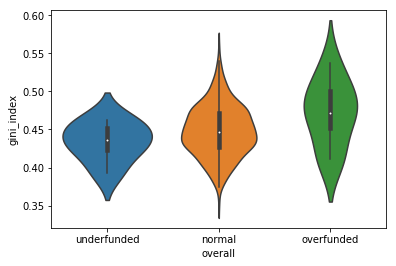

In [137]:
ax=sns.violinplot(x='overall', y='gini_index',data=df)
ax.set_xticklabels(['underfunded','normal','overfunded'])
plt.show()
#sns.violinplot(x='overall', y='% asian',data=df)